In [1]:
from efficientnet_pytorch import EfficientNet

import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax
import cv2
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from tqdm import tqdm
from albumentations import *
from albumentations.pytorch import ToTensor
import gc

import warnings
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/home/renat/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Text(0.5, 1.0, 'Scab')

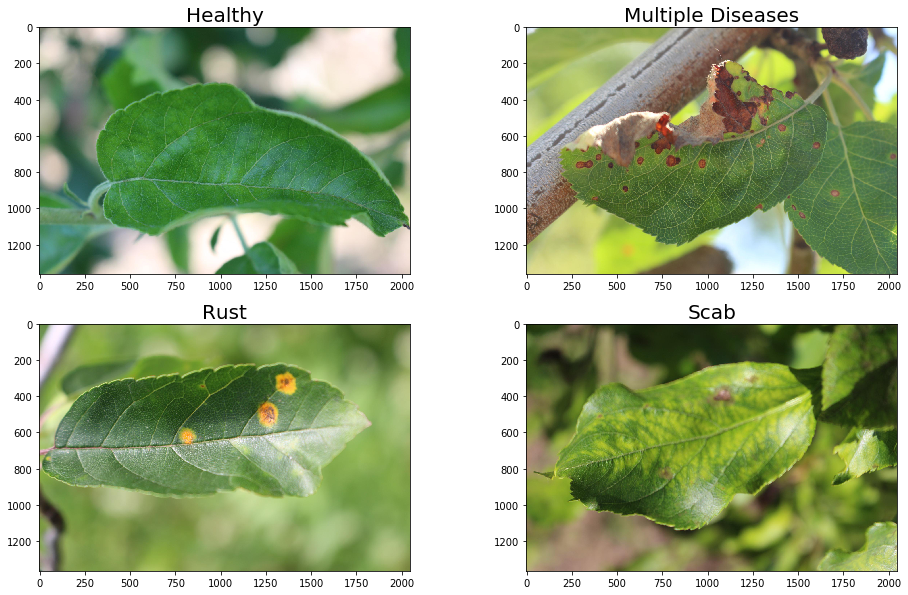

In [2]:
im_healthy = plt.imread('images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

In [3]:
IMAGE_FOLDER = 'image_pickles/'

def get_image_path(filename):
    return (IMAGE_FOLDER + filename + '.npy')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['image_path'] = train['image_id'].apply(get_image_path)
test['image_path'] = test['image_id'].apply(get_image_path)
train_labels = train.loc[:, 'healthy':'scab']
train_paths = train.image_path
test_paths = test.image_path

In [5]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

In [10]:
class LeafDataset(Data.Dataset):
    def __init__(self, image_paths, labels = None, train = True, test = False):
        self.paths = image_paths
        self.test = test
        if self.test == False:
            self.labels = labels
        self.train = train
        self.train_transform = Compose([HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                                  OneOf([IAAEmboss(p=1),
                                         IAASharpen(p=1),
                                         Blur(p=1)], p=0.5),
                                  IAAPiecewiseAffine(p=0.5)])
        self.test_transform = Compose([HorizontalFlip(p=0.5),
                                       VerticalFlip(p=0.5),
                                       ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
        self.default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()]) #normalized for pretrained network
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i):
        image = np.load(self.paths[i]) #load from .npy file!
        print(image.shape)
        if self.test==False:
            label = torch.tensor(np.argmax(self.labels.loc[i,:].values)) #loss function used later doesnt take one-hot encoded labels, so convert it using argmax
        if self.train:
            image = self.train_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        elif self.test:
            image = self.test_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        else:
            image = self.default_transform(image=image)['image']
        
        if self.test==False:
            return image, label
        return image

In [11]:
def train_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Training')
    
    for _, (images, labels) in enumerate(loader):
        
        images, labels = images.to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        predictions = net(images)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
        
    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/TRAIN_SIZE, accuracy

def valid_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (images, labels) in enumerate(loader):
            
            images, labels = images.to(device), labels.to(device)
            net.eval()
            predictions = net(images)
            loss = loss_fn(predictions, labels)
            
            running_loss += loss.item()*labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = accuracy_score(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat

def test_fn(net, loader):

    preds_for_output = np.zeros((1,4))
    
    with torch.no_grad():
        pbar = tqdm(total = len(loader))
        for _, images in enumerate(loader):
            images = images.to(device)
            net.eval()
            predictions = net(images)
            preds_for_output = np.concatenate((preds_for_output, predictions.cpu().detach().numpy()), 0)
            pbar.update()
    
    pbar.close()
    return preds_for_output

In [12]:
BATCH_SIZE = 4
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]
MODEL_NAME = 'efficientnet-b5'
device = 'cuda'
lr = 8e-4

In [13]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths, train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

In [14]:
model = EfficientNet.from_pretrained(MODEL_NAME)

num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,4, bias = True))

model.to(device)
optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b5


In [15]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [16]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_fn(model, loader = trainloader)
    vl, va, conf_mat = valid_fn(model, loader = validloader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        path = 'epoch' + str(epoch) + '.pt'
        torch.save(model.state_dict(), path)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    
'''Output hidden. Unhide to see training log'''

Training:   0%|          | 0/364 [00:00<?, ?it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   0%|          | 1/364 [00:00<05:02,  1.20it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   1%|          | 2/364 [00:01<04:04,  1.48it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   1%|          | 3/364 [00:01<03:26,  1.75it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   1%|          | 4/364 [00:01<02:57,  2.02it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   1%|▏         | 5/364 [00:02<02:38,  2.27it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   2%|▏         | 6/364 [00:02<02:23,  2.49it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   2%|▏         | 7/364 [00:02<02:14,  2.66it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   2%|▏         | 8/364 [00:03<02:07,  2.80it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   2%|▏         | 9/364 [00:03<02:02,  2.91it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   3%|▎         | 10/364 [00:03<01:58,  2.99it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   3%|▎         | 11/364 [00:03<01:55,  3.06it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   3%|▎         | 12/364 [00:04<01:53,  3.09it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   4%|▎         | 13/364 [00:04<01:52,  3.13it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Training:   4%|▍         | 14/364 [00:04<01:51,  3.15it/s]

(545, 545, 3)
(545, 545, 3)
(545, 545, 3)


Traceback (most recent call last):
  File "/home/renat/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/renat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/renat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/renat/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Plots of training and validation loss and accuracy

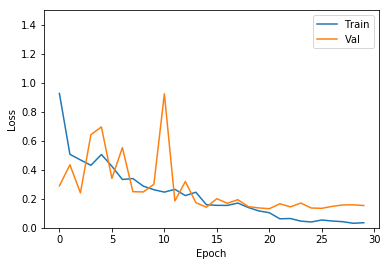

In [13]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

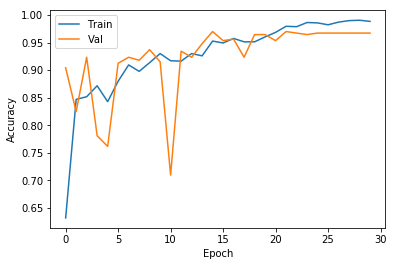

In [14]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

## Confusion matrix

Computed on the validation set on the last epoch

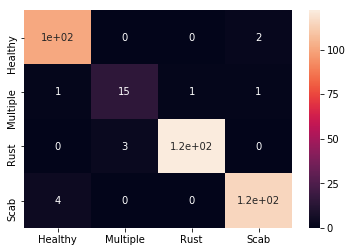

In [15]:
labels = ['Healthy', 'Multiple','Rust','Scab']
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)

## Perform inference on test data

TTA (Test Time Augmentation): perform inference on augmented versions of the test data and average the scores.

In [16]:
subs = []
for i in range(5): #average over 5 runs
    out = test_fn(model, testloader)
    output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_eff1 = sum(subs)/5

100%|██████████| 456/456 [00:36<00:00, 12.60it/s]


In [17]:
sub1 = sub_eff1.copy()
sub1['image_id'] = test.image_id
sub1 = sub1[['image_id','healthy','multiple_diseases','rust','scab']]
sub1.to_csv('submission_efficientnet1.csv', index = False)

## Clear GPU memory

Delete the model from memory to restart the training

In [18]:
del model
del optimizer
del scheduler
torch.cuda.empty_cache()

## Second run

Cells hidden, it is the same as above.

In [19]:
model = EfficientNet.from_pretrained(MODEL_NAME)

num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,4, bias = True))

model.to(device)
optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)

Loaded pretrained weights for efficientnet-b5


In [20]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [21]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_fn(model, loader = trainloader)
    vl, va, conf_mat = valid_fn(model, loader = validloader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        path = 'epoch' + str(epoch) + '.pt'
        torch.save(model.state_dict(), path)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    
'''Output hidden. Unhide to see training log'''


Epoch: 0, Train loss: 0.9327454103955201, Val loss: 0.2680562391264798, Train acc: 0.6243131868131868, Val acc: 0.9397260273972603



Epoch: 1, Train loss: 0.40290896917928704, Val loss: 0.34722222351048093, Train acc: 0.8784340659340659, Val acc: 0.915068493150685



Epoch: 2, Train loss: 0.4270627425758393, Val loss: 0.7999557580033394, Train acc: 0.8708791208791209, Val acc: 0.673972602739726



Epoch: 3, Train loss: 0.3838202507531905, Val loss: 0.44659869409587283, Train acc: 0.8907967032967034, Val acc: 0.8849315068493151



Epoch: 4, Train loss: 0.3275593303880849, Val loss: 0.29709761942902657, Train acc: 0.907967032967033, Val acc: 0.9123287671232877



Epoch: 5, Train loss: 0.3840390191628383, Val loss: 0.3482976031630007, Train acc: 0.8791208791208791, Val acc: 0.9095890410958904



Epoch: 6, Train loss: 0.3326171208377723, Val loss: 0.795185874586236, Train acc: 0.8997252747252747, Val acc: 0.7890410958904109



Epoch: 7, Train loss: 0.2844694319007161, Val loss: 0.2774475149912377, Train acc: 0.9127747252747253, Val acc: 0.9260273972602739



Epoch: 8, Train loss: 0.25771157852895965, Val loss: 0.18892491451681476, Train acc: 0.9168956043956044, Val acc: 0.9397260273972603



Epoch: 9, Train loss: 0.19921705896382805, Val loss: 0.20466699502239488, Train acc: 0.9347527472527473, Val acc: 0.936986301369863



Epoch: 10, Train loss: 0.21035653037520555, Val loss: 0.15489853081637867, Train acc: 0.9320054945054945, Val acc: 0.958904109589041



Epoch: 11, Train loss: 0.19448402323401892, Val loss: 0.13533778517213585, Train acc: 0.9409340659340659, Val acc: 0.9616438356164384



Epoch: 12, Train loss: 0.15150163858965204, Val loss: 0.24650251669426487, Train acc: 0.9539835164835165, Val acc: 0.9068493150684932



Epoch: 13, Train loss: 0.14472284180286166, Val loss: 2.4819584114910804, Train acc: 0.9512362637362637, Val acc: 0.6246575342465753



Epoch: 14, Train loss: 0.13179273837870295, Val loss: 0.14735515215625503, Train acc: 0.9581043956043956, Val acc: 0.9698630136986301



Epoch: 15, Train loss: 0.08832745479194673, Val loss: 0.18519723839955787, Train acc: 0.9732142857142857, Val acc: 0.9315068493150684



Epoch: 16, Train loss: 0.09780253117883599, Val loss: 0.16749303651182618, Train acc: 0.9732142857142857, Val acc: 0.958904109589041



Epoch: 17, Train loss: 0.07024301678597272, Val loss: 0.1501690291378596, Train acc: 0.9800824175824175, Val acc: 0.958904109589041



Epoch: 18, Train loss: 0.07083894746316659, Val loss: 0.16393932773642345, Train acc: 0.9773351648351648, Val acc: 0.9561643835616438



Epoch: 19, Train loss: 0.06777459206980663, Val loss: 0.1589029852658102, Train acc: 0.978021978021978, Val acc: 0.9561643835616438



Epoch: 20, Train loss: 0.036233515898277474, Val loss: 0.150015856795115, Train acc: 0.989010989010989, Val acc: 0.9643835616438357



Epoch: 21, Train loss: 0.04695634568458075, Val loss: 0.16947188508020689, Train acc: 0.9855769230769231, Val acc: 0.9506849315068493



Epoch: 22, Train loss: 0.0374418318599135, Val loss: 0.16552650536576363, Train acc: 0.9883241758241759, Val acc: 0.9726027397260274



Epoch: 23, Train loss: 0.03052610633792458, Val loss: 0.12318955251615342, Train acc: 0.9938186813186813, Val acc: 0.9671232876712329



Epoch: 24, Train loss: 0.021323900465126874, Val loss: 0.12360845004042534, Train acc: 0.9945054945054945, Val acc: 0.9726027397260274



Epoch: 25, Train loss: 0.01771694397205835, Val loss: 0.1232237603566418, Train acc: 0.9945054945054945, Val acc: 0.9698630136986301



Epoch: 26, Train loss: 0.01083039885366356, Val loss: 0.1214485811860594, Train acc: 0.9986263736263736, Val acc: 0.9726027397260274



Epoch: 27, Train loss: 0.01232564342873437, Val loss: 0.12327294088389776, Train acc: 0.9979395604395604, Val acc: 0.9671232876712329



Epoch: 28, Train loss: 0.01126051956153178, Val loss: 0.1208203717453839, Train acc: 0.9979395604395604, Val acc: 0.9726027397260274


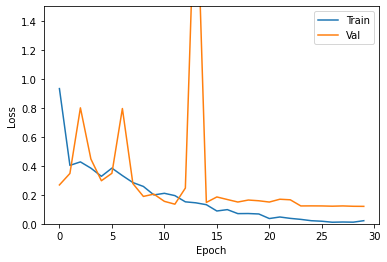

In [22]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

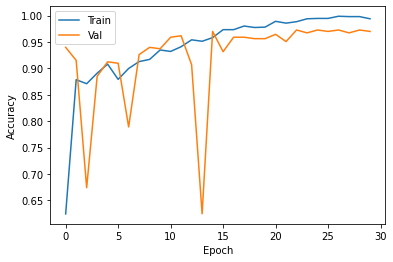

In [23]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

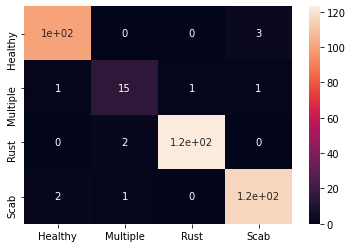

In [24]:
labels = ['Healthy', 'Multiple','Rust','Scab']
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)

In [25]:
subs = []
for i in range(5): #average over 5 runs
    out = test_fn(model, testloader)
    output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_eff2 = sum(subs)/5

In [26]:
sub2 = sub_eff2.copy()
sub2['image_id'] = test.image_id
sub2 = sub2[['image_id','healthy','multiple_diseases','rust','scab']]
sub2.to_csv('submission_efficientnet2.csv', index = False)

## Ensemble process

Average the predictions from the two models and create submission

In [27]:
sub = (sub_eff1 + sub_eff2)/2
sub['image_id'] = test.image_id
sub = sub[['image_id','healthy','multiple_diseases','rust','scab']]
sub.to_csv('submission.csv', index = False)

### *Thanks for reading!*

### <span style="color:red">Please upvote if you found this useful :)</span>